In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests 
file_url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    
r = requests.get(file_url, stream = True) 

with open("/content/drive/MyDrive/Semester 7/TKC/cifar-100-python.tar.gz", "wb") as file: 
    for block in r.iter_content(chunk_size = 1024): 
        if block: 
            file.write(block)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [ ]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
data_dir = "/content/drive/MyDrive/Semester 7/TKC/"

model_name = "resnet"

num_classes = 100

batch_size = 512

num_epochs = 5

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 5)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iters = 0

            for inputs, labels in dataloaders[phase]:
                iters += inputs.size(0)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True, is_feature_extracting=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet101
        """
        model = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model, is_feature_extracting)
        num_ftrs = model.fc.in_features
        model.avgpool = nn.AvgPool2d(kernel_size=1, stride=1, padding=0)
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 32    

    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

In [ ]:
# Initialize the model for this run
model_t, input_size = initialize_model(model_name, num_classes, use_pretrained=True, is_feature_extracting=False)
# Send the model to GPU
model_t = model_t.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
def dataLoader(is_train='train', cuda=True, batch_size=512, shuffle=True):
        if is_train == 'train':
            trans = [transforms.RandomHorizontalFlip(),
                     transforms.RandomCrop(32, padding=4),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100(root=data_dir, download = True, train=True, transform=trans)
        else:
            trans = [transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100(data_dir, train=False, transform=trans)

        return data_set

dataset = {}
for phase in ['train', 'val']:
    dataset[phase] = dataLoader(phase)

dataloaders_dict = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Using downloaded and verified file: /content/drive/MyDrive/Semester 7/TKC/cifar-100-python.tar.gz
Extracting /content/drive/MyDrive/Semester 7/TKC/cifar-100-python.tar.gz to /content/drive/MyDrive/Semester 7/TKC/


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def param2update(model, is_feature_extract=False):
    params_to_update = model.parameters()
    print("Params to learn:")
    if is_feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    return params_to_update

In [ ]:
params_to_update = param2update(model_t)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_class):
        super(ResNet, self).__init__()
        net = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(
            net.conv1,
            net.bn1,
            net.relu,
            net.maxpool,
            net.layer1,
            net.layer2,
            net.layer3,
            net.layer4,
            nn.AvgPool2d(kernel_size=1, stride=1, padding=0),
        )
        num_ftrs = net.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_config_optim(self, lr, lrp):
        return [{ 'params': self.backbone.parameters(), 'lr': lr*lrp},
                {'params': self.classifier.parameters()}]

In [ ]:
model_ftr = ResNet(num_classes)
model_ftr.to(device)

lr = 0.05
# optimizer_ft = optim.Adam(model_ft.get_config_optim(lr, 0.1), lr=lr, betas=(0.9, 0.999))
optimizer_ftr = optim.SGD(model_ftr.get_config_optim(lr, 0.1), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model_ftr, hist_ftr = train_model(model_ftr, dataloaders_dict, criterion, optimizer_ftr, num_epochs=num_epochs)

Epoch 0/4
-----


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.9980 Acc: 0.2756
val Loss: 2.2176 Acc: 0.4190

Epoch 1/4
-----
train Loss: 1.9474 Acc: 0.4696
val Loss: 1.8159 Acc: 0.5026

Epoch 2/4
-----
train Loss: 1.6076 Acc: 0.5472
val Loss: 1.6823 Acc: 0.5360

Epoch 3/4
-----
train Loss: 1.3802 Acc: 0.6055
val Loss: 1.6550 Acc: 0.5479

Epoch 4/4
-----
train Loss: 1.2189 Acc: 0.6445
val Loss: 1.5944 Acc: 0.5700

Training complete in 181m 51s
Best val Acc: 0.570000


In [ ]:
def plotacc(hist_ftr, num_epochs):
    ftr_hist = []
    
    ftr_hist = [h.cpu().numpy() for h in hist_ftr]

    plt.title("Validation Accuracy")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")

    plt.plot(range(1,num_epochs+1),ftr_hist,label="Finetune-relearn")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 2.0))
    plt.legend()
    plt.show()
  

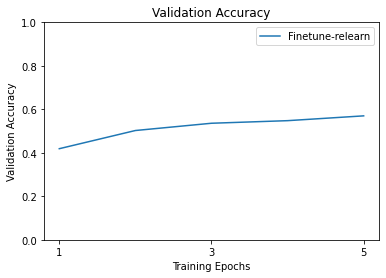

In [ ]:
plotacc(hist_ftr, num_epochs)

In [ ]:
# save parameters
def save_model(save_path):
    torch.save(model_ftr.cpu().state_dict(), save_path)
    
save_path = '/content/drive/MyDrive/Semester 7/TKC/model_ftr_587.pth'
save_model(save_path)